In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
from math import sqrt, pi, log, exp
from scipy.constants import c, h

In [2]:
def get_center(filename):
    img = fits.open(filename)
    data = img[0].data
    img.close()

    seznam = []
    for i in range(len(data[:,0])):
        seznam.append([max(data[i,:]), i])
    y = max(seznam)[1]
    for i in range(len(data[max(seznam)[1],:])):
        if data[max(seznam)[1], i] == max(seznam)[0]:
            x = i

    return x, y

def get_data(filename):
    img = fits.open(filename)
    data = img[0].data
    header = img[0].header
    img.close()
    
    back = sum(sum(data[50:60, 50:60])) / 121
    data = data - back
    
    CD1_1 = header['CD1_1']
    CD1_2 = header['CD1_2']
    const = sqrt(CD1_1**2 + CD1_2**2)
    T = header['EXPTIME']
    S = header['AREA']
    wave = 695e-9
    F0 = 2.73e-9 
    
    x, y = get_center(filename)
    cor_data, mag, X = [], [], []
    for i in range(121):
        cor_data.append(data[y, x + i] / T / (const * 3600)**2 / S * h * c / wave)
        mag.append(-2.5 * log(cor_data[i] / F0, 10))
        X.append(i * const * 3600)
            
    return X, cor_data, mag

def get_data_hst(filename):
    img = fits.open(filename)
    data = img[0].data
    header = img[0].header
    img.close()
    
    CD1_1 = header['CD1_1']
    CD1_2 = header['CD1_2']
    const = sqrt(CD1_1**2 + CD1_2**2)
    PHOTFLAM = header['PHOTFLAM']
    PHOTZPT = header['PHOTZPT']
    F0 = 2.73e-9 
    
    x, y = get_center(filename)
    cor_data, mag, X, I = [], [], [], []
    for i in range(620):
        cor_data.append(data[y, x + 4 + i] / (const * 3600)**2)
        mag.append(-2.5 * log(PHOTFLAM * abs(cor_data[i]), 10) + PHOTZPT)
        X.append(i * const * 3600)
        I.append(F0 * 10**(-0.4 * mag[i]))
        
    return X, cor_data, mag,  I

def get_half(X, cor_data):
    X_new, cor_data_new = [], []
    for i in range(len(cor_data)):
        if X[i] > 10:
            X_new.append(X[i])
            cor_data_new.append(cor_data[i])
            
    for i in range(len(cor_data_new)):
        if round(sum(cor_data_new[:i]) * 1e14, 3) <= round(sum(cor_data_new) / 2 * 1e14, 3):
            r_0, I_0 = X_new[i], (cor_data_new[i])
            
    return r_0, I_0

def main_vac(vyskov, hst):
    X, cor_data, mag = get_data(vyskov)
    X_hst, cor_data_hst, mag_hst, I_hst = get_data_hst(hst)
    r_0, I_0 = get_half(X, cor_data)
    r_0_hst, I_0_hst = get_half(X_hst, I_hst)
    F0 = 2.73e-9
    
    vac, vac_hst, mag_vac, mag_vac_hst = [], [], [], []
    for i in range(len(X)):
        vac.append(I_0 * exp(7.669 * (1 - (X[i] / r_0)**(1/4))))
        vac_hst.append(I_0_hst * exp(7.669 * (1 - (X[i] / r_0_hst)**(1/4))))
        mag_vac.append(-2.5 * log(vac[i] / F0, 10))
        mag_vac_hst.append(-2.5 * log(vac_hst[i] / F0, 10))
     
    fig = plt.figure(figsize=(6.5, 4.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('Ověření De-Vaucoulerova zákona na profilu galaxie M87')
    ax.plot(X, mag, '+', label='data z Whyškova', c='C0')
    ax.plot(X_hst, mag_hst, '+', label='data z HST', c='C1')
    ax.plot(X, mag_vac, label='De Vaucouleurův zákon pro Whyškov', c='C2') 
    ax.plot(X, mag_vac_hst, label='De Vaucouleurův zákon pro HST', c='C3')
    ax.set_xlabel('$R$ ["]', size=12)
    ax.set_ylabel('$\mu$ [mag$\,$/$\,$"$^2$]', size=12)
    ax.legend()
    plt.gca().invert_yaxis()
    plt.savefig('de_vac.png', dpi=120)

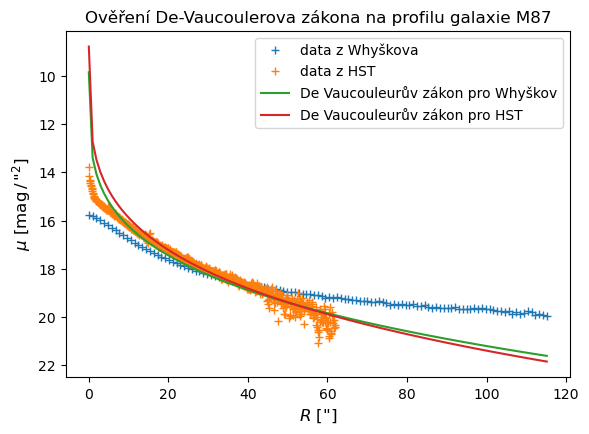

In [4]:
main_vac('M87_R_cal.fits', 'hubble.fits')